# Logistic Regression

## Importing the libraries

In [434]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [435]:
# pyspark_df = spark.table("sd_bdc_demo.k_cluster_logistic_regression.1_am_workday_updated_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [436]:
df = pd.read_csv("1_am_workday_updated_data/1_am_workday_updated_data.csv")


In [437]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [438]:
print(df.columns)

Index(['Current_Role', 'Zip_Code', 'Employee_ID', 'Employee_Annual_Salary',
       'Monthly_Medical_contribution', 'Monthly_Dental_Contribution',
       'Monthly_Vision_Contribution', 'Bonus', 'Years_Of_Service',
       'Department', 'Gender', 'Employee_HR_rate', 'Hours_per_week',
       'Years_Since_Last_Promotion', 'age', 'left'],
      dtype='object')


In [439]:
print(df.head())

                Current_Role  Zip_Code  Employee_ID  Employee_Annual_Salary  \
0   Senior Software Engineer     94103           57                  130800   
1   Associate Data Scientist     94111           58                   74250   
2  Associate Product Manager     10009           59                  125850   
3           Business Analyst     60605           60                   84750   
4    Chief Operating Officer      2101           61                  300000   

   Monthly_Medical_contribution  Monthly_Dental_Contribution  \
0                           130                           35   
1                           105                           30   
2                           130                           35   
3                           105                           30   
4                           230                           55   

   Monthly_Vision_Contribution  Bonus  Years_Of_Service    Department  \
0                           19  13865               5.2   Engineeri

In [440]:
print(df.shape)

(100, 16)


## Encoding categorical data

In [441]:
df_encoded = pd.get_dummies(df, columns=['Current_Role', 'Department', 'Gender'], drop_first=False).astype(int)


In [442]:
print(df_encoded.head())

   Zip_Code  Employee_ID  Employee_Annual_Salary  \
0     94103           57                  130800   
1     94111           58                   74250   
2     10009           59                  125850   
3     60605           60                   84750   
4      2101           61                  300000   

   Monthly_Medical_contribution  Monthly_Dental_Contribution  \
0                           130                           35   
1                           105                           30   
2                           130                           35   
3                           105                           30   
4                           230                           55   

   Monthly_Vision_Contribution  Bonus  Years_Of_Service  Employee_HR_rate  \
0                           19  13865                 5                60   
1                           17   4344                 1               117   
2                           19  15920                 1               1

In [443]:
print(df_encoded.shape)

(100, 105)


## Removing `left` column

In [444]:
df_no_left = df_encoded.drop(columns=['left'])
X = df_no_left

In [445]:
print(X.head())


   Zip_Code  Employee_ID  Employee_Annual_Salary  \
0     94103           57                  130800   
1     94111           58                   74250   
2     10009           59                  125850   
3     60605           60                   84750   
4      2101           61                  300000   

   Monthly_Medical_contribution  Monthly_Dental_Contribution  \
0                           130                           35   
1                           105                           30   
2                           130                           35   
3                           105                           30   
4                           230                           55   

   Monthly_Vision_Contribution  Bonus  Years_Of_Service  Employee_HR_rate  \
0                           19  13865                 5                60   
1                           17   4344                 1               117   
2                           19  15920                 1               1

In [446]:
print(X.shape)

(100, 104)


## Feature Scaling

In [447]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# List of columns to scale
columns_to_scale = [
    'Employee_Annual_Salary', 'Monthly_Medical_contribution',
    'Monthly_Dental_Contribution', 'Monthly_Vision_Contribution', 'Bonus',
    'Years_Of_Service', 'Employee_HR_rate', 'Hours_per_week',
    'Years_Since_Last_Promotion', 'age'
]

# Fit sc on training data and transform both training and test sets
X_scaled = X.copy()

X_scaled[columns_to_scale] = sc.fit_transform(X_scaled[columns_to_scale])


In [448]:
print(X_scaled)

    Zip_Code  Employee_ID  Employee_Annual_Salary  \
0      94103           57                0.042182   
1      94111           58               -1.037434   
2      10009           59               -0.052320   
3      60605           60               -0.836975   
4       2101           61                3.272440   
..       ...          ...                     ...   
95     98103          152               -0.773018   
96     78723          153               -0.624106   
97     78712          154               -0.773018   
98     78703          155               -0.778746   
99     98109          156                3.272440   

    Monthly_Medical_contribution  Monthly_Dental_Contribution  \
0                       0.060356                     0.060356   
1                      -0.801873                    -0.801873   
2                       0.060356                     0.060356   
3                      -0.801873                    -0.801873   
4                       3.509273      

In [449]:
print(X_scaled.shape)

(100, 104)


### Removing `Employee ID` & `Zip Code` in `X_scaled`

In [450]:
print(type(X_scaled))

<class 'pandas.core.frame.DataFrame'>


In [451]:
X_scaled_new = X_scaled.drop(columns=['Employee_ID', 'Zip_Code'])
print(X_scaled_new)

    Employee_Annual_Salary  Monthly_Medical_contribution  \
0                 0.042182                      0.060356   
1                -1.037434                     -0.801873   
2                -0.052320                      0.060356   
3                -0.836975                     -0.801873   
4                 3.272440                      3.509273   
..                     ...                           ...   
95               -0.773018                     -0.801873   
96               -0.624106                     -0.801873   
97               -0.773018                     -0.801873   
98               -0.778746                     -0.801873   
99                3.272440                      3.509273   

    Monthly_Dental_Contribution  Monthly_Vision_Contribution     Bonus  \
0                      0.060356                     0.060356 -0.220739   
1                     -0.801873                    -0.801873 -0.747377   
2                      0.060356                     0.060

## Using the elbow method to find the optimal number of clusters

In [452]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_range = range(2,11)
wcss = []
silhouette_scores = []
for i in cluster_range:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled_new)
    labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled_new, labels))


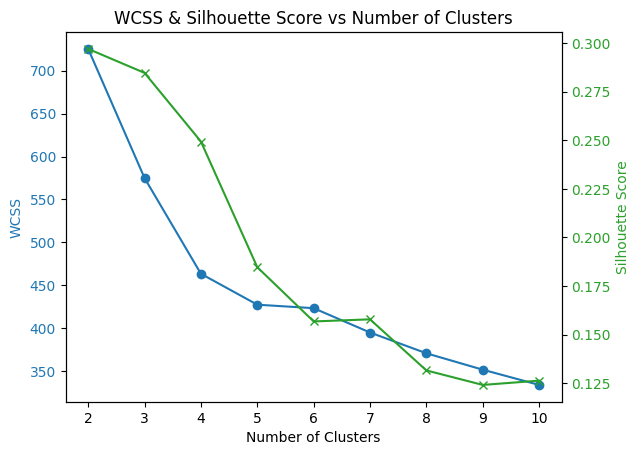

In [453]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(cluster_range, wcss, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(cluster_range, silhouette_scores, color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('WCSS & Silhouette Score vs Number of Clusters')
plt.show()

### Saving the no of clusters, wcss & silhouette score in a new table

In [454]:
print(wcss)
print(list(range(1,11)))
cluster_eval_df = pd.DataFrame({
    'Number_of_Clusters': list(cluster_range),
    'WCSS': wcss,
    'Silhouette_Score': silhouette_scores
})


[725.2150277999308, 574.9230855245506, 463.52438278163294, 427.5515819349617, 423.4998451360009, 395.1824519682011, 370.98477315910077, 351.89606532903014, 334.17450826689253]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [455]:
# Create the folder if it doesn't exist
os.makedirs("2_1_am_workday_elbow_analysis_data", exist_ok=True)

# Save the Excel file inside the folder
cluster_eval_df.to_csv("2_1_am_workday_elbow_analysis_data/2_1_am_workday_elbow_analysis_data.csv", index=False)

In [456]:
# spark_df = spark.createDataFrame(cluster_eval_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_1_am_workday_elbow_analysis_data")

## Training the K-Means model on the dataset

In [457]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(X_scaled_new)

KMeans(n_clusters=5, random_state=42)

## Prediction

In [458]:
y_kmeans = kmeans.predict(X_scaled_new)

In [459]:
print(y_kmeans)

[0 4 4 4 2 2 0 4 0 0 4 0 0 0 4 1 1 0 1 1 1 1 1 0 0 4 4 4 0 4 4 4 4 3 3 4 4
 0 4 4 4 4 4 3 3 3 1 3 3 3 3 4 0 0 4 0 4 0 1 1 1 1 1 3 1 3 0 3 3 1 0 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 4 1 3 0 4 0 0 4 2]


In [460]:
print(len(y_kmeans))

100


### Saving the output as new table

In [461]:
df_new = df.copy()

In [462]:
df_new['Cluster_label'] = y_kmeans


In [463]:
print(df_new)

                 Current_Role  Zip_Code  Employee_ID  Employee_Annual_Salary  \
0    Senior Software Engineer     94103           57                  130800   
1    Associate Data Scientist     94111           58                   74250   
2   Associate Product Manager     10009           59                  125850   
3            Business Analyst     60605           60                   84750   
4     Chief Operating Officer      2101           61                  300000   
..                        ...       ...          ...                     ...   
95           Technical Writer     98103          152                   88100   
96                UX Designer     78723          153                   95900   
97              UX Researcher     78712          154                   88100   
98              UX Researcher     78703          155                   87800   
99           VP of Technology     98109          156                  300000   

    Monthly_Medical_contribution  Month

In [464]:
print(df_new.shape)

(100, 17)


In [465]:
# Create the folder if it doesn't exist
os.makedirs("2_9_am_workday_cluster_updated_data", exist_ok=True)

# Save the Excel file inside the folder
df_new.to_csv("2_9_am_workday_cluster_updated_data/2_9_am_workday_cluster_updated_data.csv", index=False)

In [466]:
# spark_df = spark.createDataFrame(df_new)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_9_am_workday_cluster_updated_data")

### Saving selected columns as the output of new table

In [467]:
df_selected = df_new[['Employee_ID', 'Cluster_label', 'age']]


In [468]:
# Create the folder if it doesn't exist
os.makedirs("2_3_am_workday_cluster_label_vs_age_data", exist_ok=True)

# Save the Excel file inside the folder
df_selected.to_csv("2_3_am_workday_cluster_label_vs_age_data/2_3_am_workday_cluster_label_vs_age_data.csv", index=False)

In [469]:
# spark_df = spark.createDataFrame(df_selected)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_3_am_workday_cluster_label_vs_age_data")

### Saving the output data cluster wise

In [470]:
df_cluster_0 = df_new[df_new['Cluster_label'] == 0].drop(columns=['Cluster_label'])
df_cluster_1 = df_new[df_new['Cluster_label'] == 1].drop(columns=['Cluster_label'])
df_cluster_2 = df_new[df_new['Cluster_label'] == 2].drop(columns=['Cluster_label'])
df_cluster_3 = df_new[df_new['Cluster_label'] == 3].drop(columns=['Cluster_label'])
df_cluster_4 = df_new[df_new['Cluster_label'] == 4].drop(columns=['Cluster_label'])


In [471]:
print(df_cluster_0.shape)

(22, 16)


In [472]:
# Create the folder if it doesn't exist
os.makedirs("2_4_am_workday_cluster_0_updated_data", exist_ok=True)

# Save the Excel file inside the folder
df_cluster_0.to_csv("2_4_am_workday_cluster_0_updated_data/2_4_am_workday_cluster_0_updated_data.csv", index=False)

In [473]:
# spark_df = spark.createDataFrame(df_cluster_0)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_4_am_workday_cluster_0_updated_data")

In [474]:
# Create the folder if it doesn't exist
os.makedirs("2_5_am_workday_cluster_1_updated_data", exist_ok=True)

# Save the Excel file inside the folder
df_cluster_1.to_csv("2_5_am_workday_cluster_1_updated_data/2_5_am_workday_cluster_1_updated_data.csv", index=False)

In [475]:
# spark_df = spark.createDataFrame(df_cluster_1)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_5_am_workday_cluster_1_updated_data")

In [476]:
# Create the folder if it doesn't exist
os.makedirs("2_6_am_workday_cluster_2_updated_data", exist_ok=True)

# Save the Excel file inside the folder
df_cluster_2.to_csv("2_6_am_workday_cluster_2_updated_data/2_6_am_workday_cluster_2_updated_data.csv", index=False)

In [477]:
# spark_df = spark.createDataFrame(df_cluster_2)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_6_am_workday_cluster_2_updated_data")

In [478]:
# Create the folder if it doesn't exist
os.makedirs("2_7_am_workday_cluster_3_updated_data", exist_ok=True)

# Save the Excel file inside the folder
df_cluster_3.to_csv("2_7_am_workday_cluster_3_updated_data/2_7_am_workday_cluster_3_updated_data.csv", index=False)

In [479]:
# spark_df = spark.createDataFrame(df_cluster_3)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_7_am_workday_cluster_3_updated_data")

In [480]:
# Create the folder if it doesn't exist
os.makedirs("2_8_am_workday_cluster_4_updated_data", exist_ok=True)

# Save the Excel file inside the folder
df_cluster_4.to_csv("2_8_am_workday_cluster_4_updated_data/2_8_am_workday_cluster_4_updated_data.csv", index=False)

In [481]:
# spark_df = spark.createDataFrame(df_cluster_4)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_8_am_workday_cluster_4_updated_data")

## Insights

<Axes: xlabel='Cluster_label', ylabel='age'>

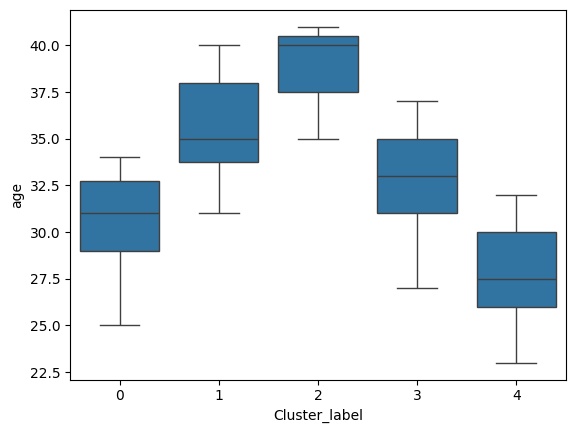

In [482]:
# Compare age distributions visually
import seaborn as sns
sns.boxplot(x='Cluster_label', y='age', data=df_new)

In [483]:
selected_cols = [
                    'Employee_Annual_Salary', 'Monthly_Medical_contribution',
                    'Monthly_Dental_Contribution', 'Monthly_Vision_Contribution', 'Bonus',
                    'Years_Of_Service', 'Employee_HR_rate', 'Hours_per_week',
                    'Years_Since_Last_Promotion', 'age', 'left'
                ]
cluster_avg = df_new.groupby('Cluster_label')[selected_cols].mean().reset_index()
print(cluster_avg)


   Cluster_label  Employee_Annual_Salary  Monthly_Medical_contribution  \
0              0            94915.909091                    109.545455   
1              1           198421.875000                    169.062500   
2              2           300000.000000                    230.000000   
3              3           138057.575758                    129.242424   
4              4            82317.307692                    105.961538   

   Monthly_Dental_Contribution  Monthly_Vision_Contribution         Bonus  \
0                    30.909091                    17.363636   7943.500000   
1                    42.812500                    22.125000  41065.562500   
2                    55.000000                    27.000000  90000.000000   
3                    34.848485                    18.939394  16239.606061   
4                    30.192308                    17.076923   5686.846154   

   Years_Of_Service  Employee_HR_rate  Hours_per_week  \
0          3.609091         85.9090

In [484]:
print(type(cluster_avg))

<class 'pandas.core.frame.DataFrame'>


### Saving the insights as new table

In [485]:
# Create the folder if it doesn't exist
os.makedirs("2_2_am_workday_cluster_insight_data", exist_ok=True)

# Save the Excel file inside the folder
cluster_avg.to_csv("2_2_am_workday_cluster_insight_data/2_2_am_workday_cluster_insight_data.csv", index=False)

In [486]:
# spark_df = spark.createDataFrame(cluster_avg)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.k_cluster_logistic_regression.2_2_am_workday_cluster_insight_data")